# Returns to Education: Old Data and New Techniques

## Tim Savage, NYUSPS Schack Institute of Real Estate


* Sources: Griliches (1977) and [data](https://vincentarelbundock.github.io/Rdatasets/csv/Ecdat/Griliches.csv)

In [1]:
%matplotlib inline
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
import pymc3 as pm
import theano
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)
warnings.simplefilter('ignore')
import datetime as dt
from fredapi import Fred
fred = Fred(api_key='30e6ecb242a73869e11cb35f6aa3afc3')

In [2]:
griliches = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/Ecdat/Griliches.csv")
griliches = griliches.drop(griliches.columns[0], 1)
griliches = griliches[['lw', 'school', 'iq', 'age', 'expr', 'tenure', 'med']]

In [3]:
# Create numpy arrays for PyMC3

lw = griliches['lw'].as_matrix()
school = griliches['school'].as_matrix()
iq = griliches['iq'].as_matrix()
age = griliches['age'].as_matrix()
expr = griliches['expr'].as_matrix()
tenure = griliches['tenure'].as_matrix()
med = griliches['med'].as_matrix()

In [4]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta1 = pm.Normal('beta1', mu=0, sd=20)
    beta2 = pm.Normal('beta2', mu=0, sd=20)
    beta3 = pm.Normal('beta3', mu=0, sd=20)
    beta4 = pm.Normal('beta4', mu=0, sd=20)
    beta5 = pm.Normal('beta5', mu=0, sd=20)
    beta6 = pm.Normal('beta6', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    # y_est is the specification of the Bayesian model to be estimated.  It is simply our CAPM.
    y_est = alpha + beta1 * school + beta2 * iq + beta3 * age + beta4 * expr + beta5 * tenure + beta6 * med 
    
    # likelihood is the likelihood function, here it is normal to be used with conjugate priors.    
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=lw)
    
    # We use the Maximum a Posteriori (MAP) values as starting values for the MCMC sampling.
    start = pm.find_MAP()
    trace = pm.sample(1000, start=start, nuts_kwargs=dict(target_accept=.9), progressbar=True)

logp = -273.44, ||grad|| = 2.1271: 100%|██████████| 72/72 [00:00<00:00, 1290.64it/s]      
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta6, beta5, beta4, beta3, beta2, beta1, alpha]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:24<00:00, 120.32draws/s]


<Figure size 720x720 with 0 Axes>

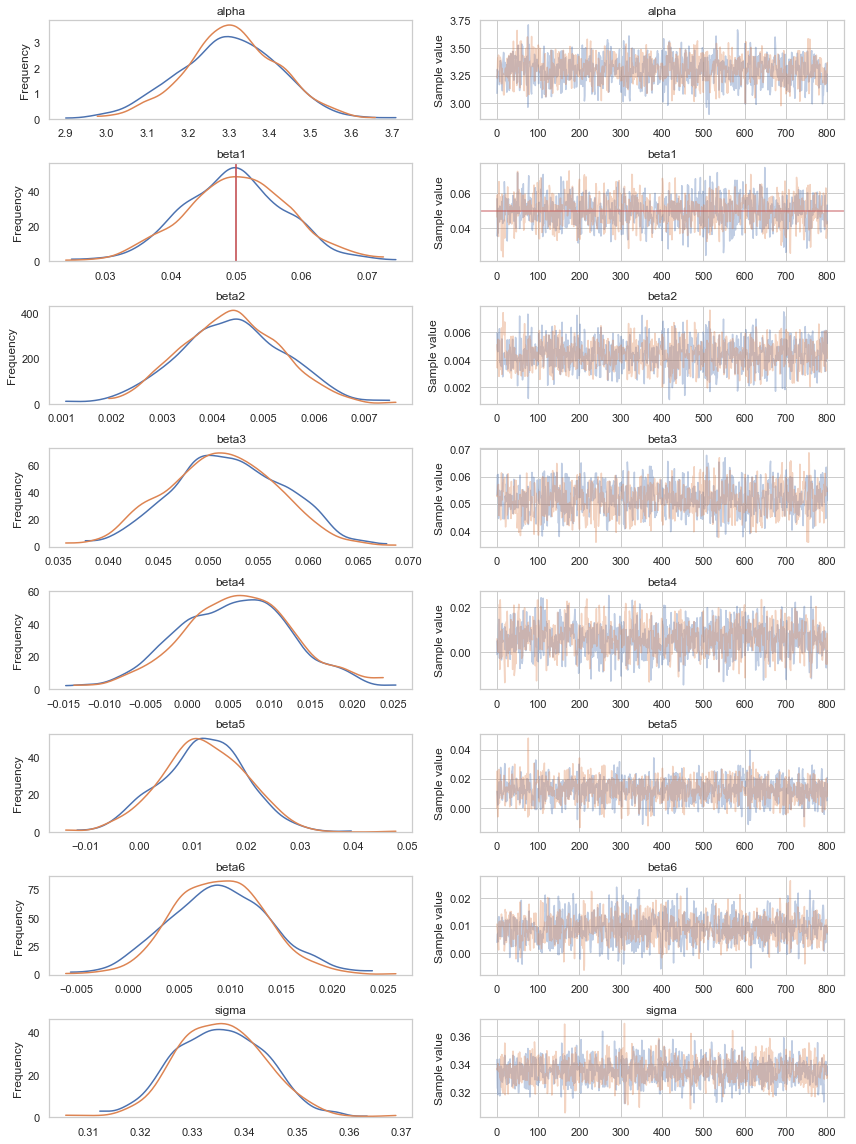

<Figure size 720x720 with 0 Axes>

In [5]:
fig = pm.traceplot(trace[199:1000], lines={'beta1': 0.05})
plt.figure(figsize = (10, 10))

In [6]:
print("The probability that returns to schooling exceed 0.05 is %f" % np.mean(trace['beta1'][199:1000] > 0.05))

The probability that returns to schooling exceed 0.05 is 0.479401


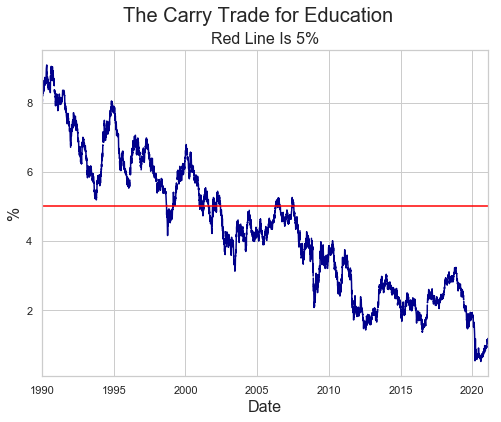

In [7]:
ten_year = fred.get_series("DGS10", observation_start='1990-01-01')
ten_year.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('The Carry Trade for Education', fontsize=20)
plt.title('Red Line Is 5%', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.axhline(5, color="red")